# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
p1 = 8/10
p2 = 2/10
entropy = - (p1 * np.log(p1) + p2 * np.log(p2))
print(round(entropy, 2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
H_Rm = p1*(1-p1) + p2*(1-p2)

H_Rl = 0
H_Rr = 0

Q = H_Rm - (10/10)*H_Rl - (0/10)*H_Rr
print(round(Q, 2))

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
prediction = np.mean(values)
print(prediction)

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    if len(np.unique(feature_vector)) == 1:
        return np.array([]), np.array([]), None, -np.inf

    sorted_idx = np.argsort(feature_vector)
    feature_sorted = feature_vector[sorted_idx]
    target_sorted = target_vector[sorted_idx]

    if feature_type == "real":
        unique_vals = np.unique(feature_sorted)
        thresholds = (unique_vals[1:] + unique_vals[:-1]) / 2
    else:
        thresholds = np.unique(feature_sorted)

    all_gains = []
    valid_thresholds = []
    best_gain = -np.inf
    best_threshold = None

    for threshold in thresholds:
        if feature_type == "real":
            left_mask = feature_sorted < threshold
        else:
            left_mask = feature_sorted == threshold

        right_mask = ~left_mask

        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            continue

        if task == "classification":
            def gini(y):
                if len(y) == 0:
                    return 0
                p = np.bincount(y) / len(y)
                return 1 - np.sum(p**2)

            gini_parent = gini(target_sorted)
            gini_left = gini(target_sorted[left_mask])
            gini_right = gini(target_sorted[right_mask])

            n_left = np.sum(left_mask)
            n_right = np.sum(right_mask)
            n_total = n_left + n_right

            gain = gini_parent - (n_left/n_total)*gini_left - (n_right/n_total)*gini_right
        else:
            var_parent = np.var(target_sorted)
            var_left = np.var(target_sorted[left_mask])
            var_right = np.var(target_sorted[right_mask])

            n_left = np.sum(left_mask)
            n_right = np.sum(right_mask)
            n_total = n_left + n_right

            gain = var_parent - (n_left/n_total)*var_left - (n_right/n_total)*var_right

        all_gains.append(gain)
        valid_thresholds.append(threshold)

        if gain > best_gain:
            best_gain = gain
            best_threshold = threshold

    return np.array(valid_thresholds), np.array(all_gains), best_threshold, best_gain

Эту функцию можно протестировать на датасете `Boston` из `fairlearn`.

Установим версию sklearn, которая содержит датасет Boston

In [7]:
!pip install fairlearn

In [8]:
from fairlearn.datasets import fetch_boston

boston = fetch_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

/usr/local/lib/python3.11/dist-packages/fairlearn/datasets/_fetch_boston.py:133: DataFairnessWarning: You are about to use a dataset with known fairness issues.
  warnings.warn(DataFairnessWarning(msg))


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

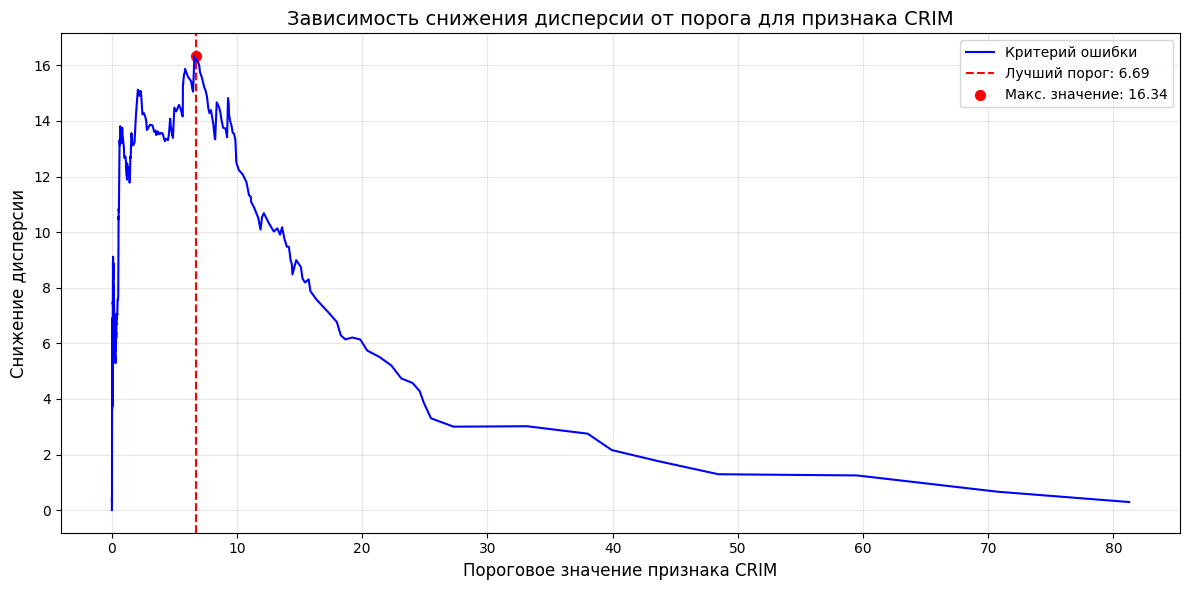

In [9]:
thresholds, gains, best_threshold, best_gain = find_best_split(
    X['CRIM'].to_numpy(),
    y,
    task="regression",
    feature_type="real"
)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, gains, 'b-', linewidth=1.5, label='Критерий ошибки')
plt.axvline(x=best_threshold, color='r', linestyle='--',
            label=f'Лучший порог: {best_threshold:.2f}')
plt.scatter(best_threshold, best_gain, color='red', s=50,
           label=f'Макс. значение: {best_gain:.2f}')

plt.xlabel('Пороговое значение признака CRIM', fontsize=12)
plt.ylabel('Снижение дисперсии', fontsize=12)
plt.title('Зависимость снижения дисперсии от порога для признака CRIM', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [10]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        """
        В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        левого детей (поддеревья для продолжения процедуры предсказания)
        """
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini is None:  # Пропускаем невалидные разбиения
                continue

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold  # маска для реального признака
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold  # маска для категориального признака
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            # Для классификации - наиболее частый класс, для регрессии - среднее
            if self.task == "classification":
                node["class"] = Counter(sub_y).most_common(1)[0][0]
            else:
                node["class"] = np.mean(sub_y)
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """

        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        if self._feature_types[feature] == "real":
            if x[feature] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

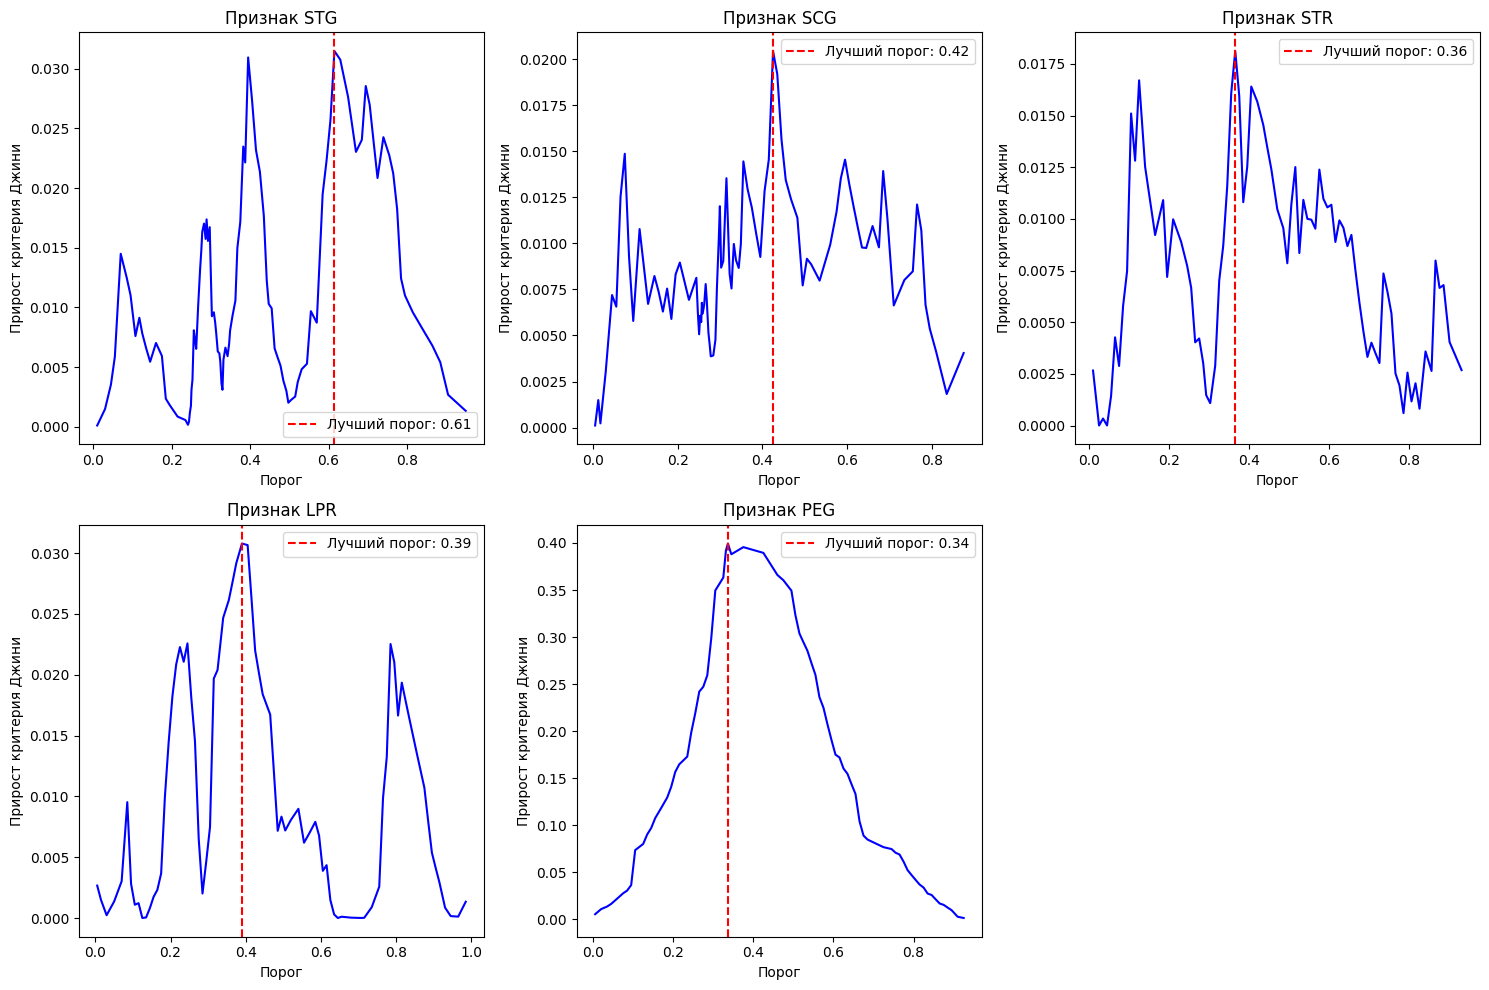

In [11]:
data = pd.read_csv('students.csv')
features = ['STG', 'SCG', 'STR', 'LPR', 'PEG']
target = 'UNS'

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    thresholds, gains, best_threshold, best_gain = find_best_split(
        data[feature].values,
        data[target].values,
        task="classification",
        feature_type="real"
    )

    if len(thresholds) > 0:
        plt.subplot(2, 3, i+1)
        plt.plot(thresholds, gains, 'b-', linewidth=1.5)
        plt.title(f'Признак {feature}')
        plt.xlabel('Порог')
        plt.ylabel('Прирост критерия Джини')

        plt.axvline(x=best_threshold, color='r', linestyle='--',
                    label=f'Лучший порог: {best_threshold:.2f}')
        plt.legend()

plt.tight_layout()
plt.show()

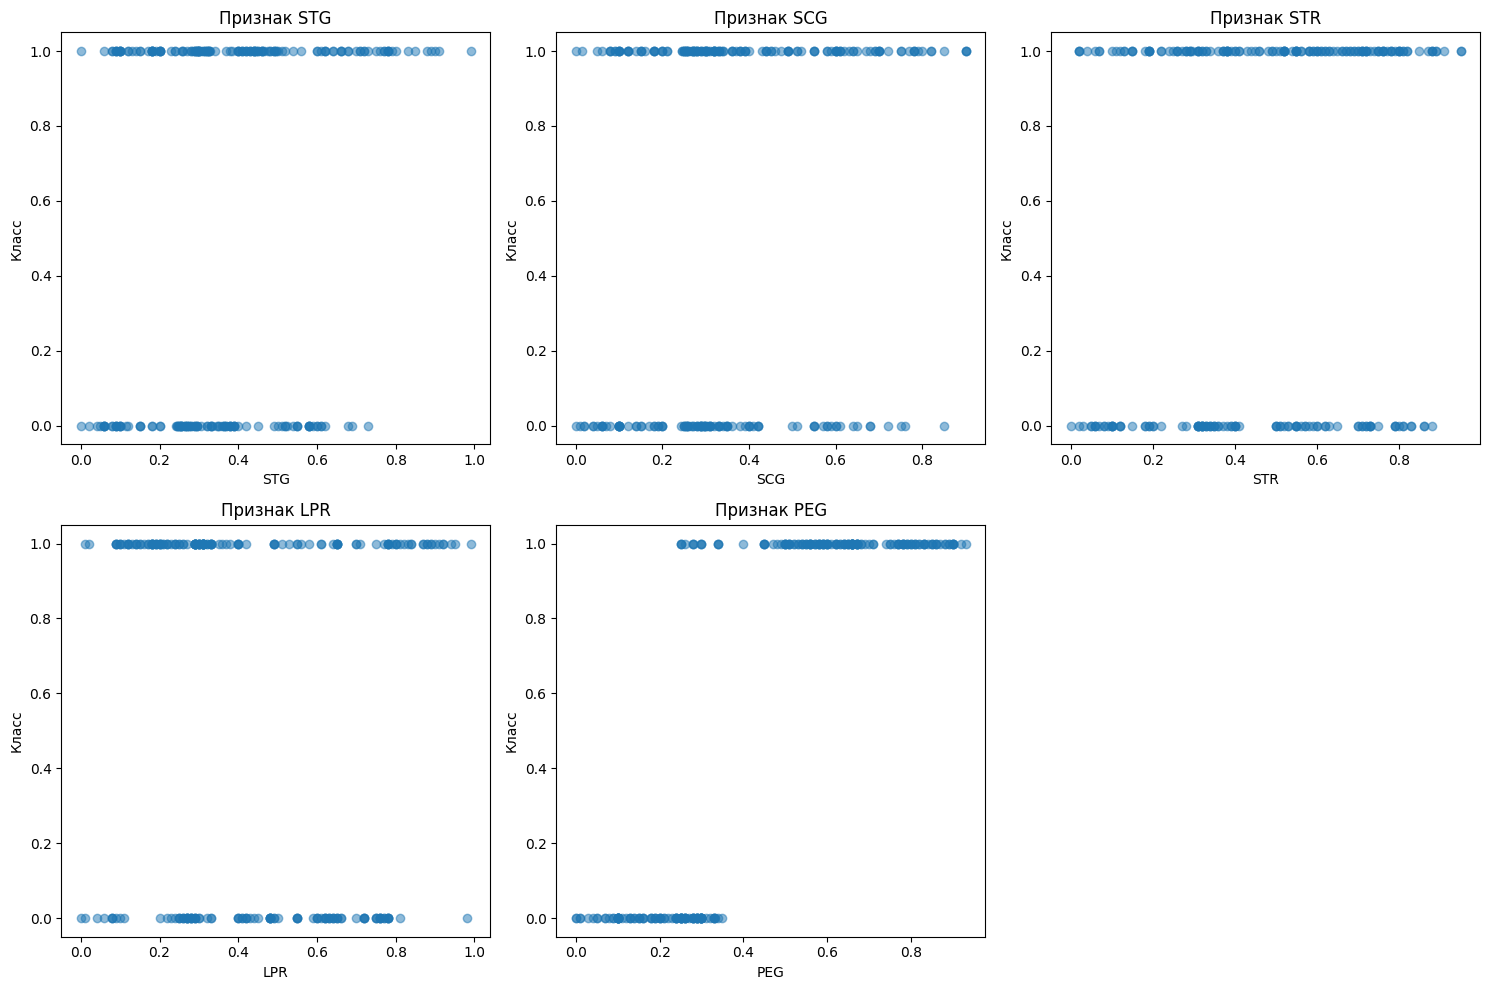

In [12]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    plt.scatter(data[feature], data[target], alpha=0.5)
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Класс')
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

1. Нужно выбрать признак с максимальным приростом критерия Джини. В нашем случае это признак PEG;
2. Да, согласуется, на диаграмме рассеяния для признака PEG можно четко выделить две области классов с малым количеством выбросов;
3. Для "хороших" признаков кривая имеет вид, напоминающий параболу;
4. В свою очередь, кривые, по которым нельзя провести хорошее разбиение на классы, имеют большое количество точек перегибов с острыми углами. Они похожи на графики с ЭКГ.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

data = pd.read_csv('agaricus-lepiota.data', header=None)

le = LabelEncoder()
for col in data.columns:
    data[col] = le.fit_transform(data[col])

X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = len(X) // 2
X_train, y_train = X[indices[:train_size]], y[indices[:train_size]]
X_test, y_test = X[indices[train_size:]], y[indices[train_size:]]

feature_types = ['categorical'] * X.shape[1]
tree = DecisionTree(feature_types=feature_types, task='classification')
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [14]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [15]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

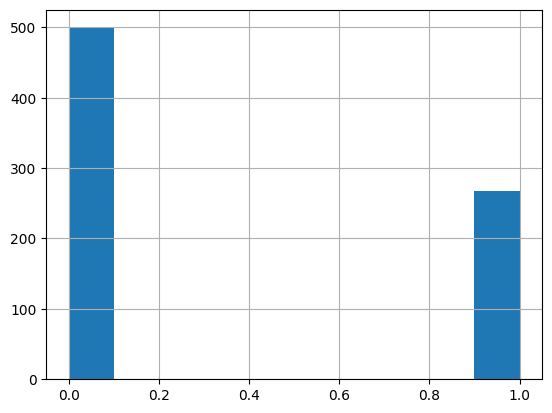

In [16]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [17]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [18]:
from sklearn.metrics import f1_score

max_depth_list = [3, 5, 7, 10, None]
min_samples_leaf_list = [1, 3, 5, 10]

best_score = -1
best_params = {}

for max_depth in max_depth_list:
    for min_samples_leaf in min_samples_leaf_list:
        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        model.fit(X_train_train, y_train_train)
        y_pred = model.predict(X_train_val)
        score = f1_score(y_train_val, y_pred)

        if score > best_score:
            best_score = score
            best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

print(f"Best params: {best_params}, F1: {best_score}")

best_model = DecisionTreeClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

print(f"DT Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"DT Precision: {precision_score(y_test, y_pred)}")
print(f"DT Recall: {recall_score(y_test, y_pred)}")
print(f"DT AUC ROC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])}")

Best params: {'max_depth': 5, 'min_samples_leaf': 5}, F1: 0.6666666666666666
DT Accuracy: 0.7705627705627706
DT Precision: 0.7142857142857143
DT Recall: 0.5625
DT AUC ROC: 0.79375


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [19]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=50,
    random_state=42
)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

print(f"Bagging Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Bagging Precision: {precision_score(y_test, y_pred)}")
print(f"Bagging Recall: {recall_score(y_test, y_pred)}")
print(f"Bagging AUC ROC: {roc_auc_score(y_test, bagging.predict_proba(X_test)[:, 1])}")

Bagging Accuracy: 0.7489177489177489
Bagging Precision: 0.6309523809523809
Bagging Recall: 0.6625
Bagging AUC ROC: 0.808319536423841


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(1, 20),
    'min_samples_split': range(2,10),
    'n_estimators': [50]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='f1', n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best F1: {grid_search.best_score_}")

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print(f"RF Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RF Precision: {precision_score(y_test, y_pred)}")
print(f"RF Recall: {recall_score(y_test, y_pred)}")
print(f"RF AUC ROC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])}")

Best params: {'max_depth': 12, 'min_samples_split': 8, 'n_estimators': 50}
Best F1: 0.6539611850138166
RF Accuracy: 0.7445887445887446
RF Precision: 0.6296296296296297
RF Recall: 0.6375
RF AUC ROC: 0.8052152317880795


- Лучший recall и AUC ROC у бэггинга

- Лучшие accuracy и precision у решающего дерева

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

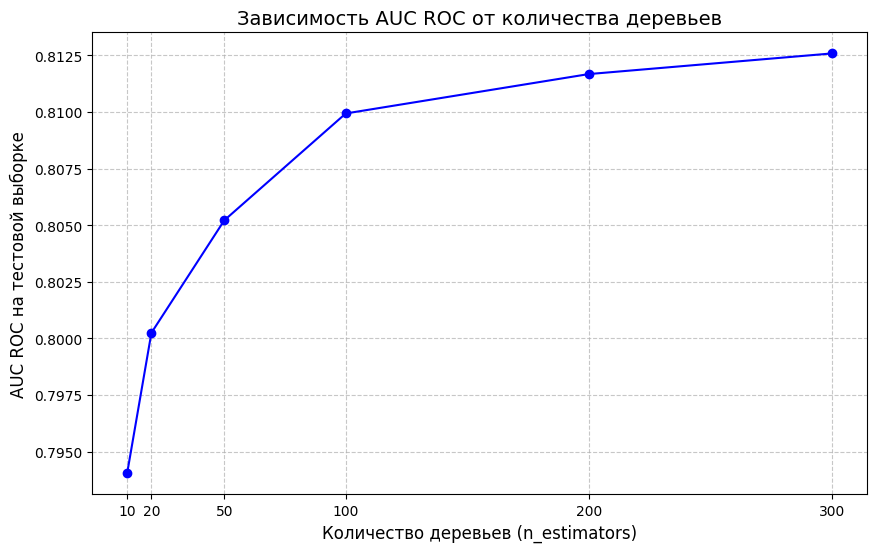

n_estimators = 10: AUC ROC = 0.7940
n_estimators = 20: AUC ROC = 0.8002
n_estimators = 50: AUC ROC = 0.8052
n_estimators = 100: AUC ROC = 0.8099
n_estimators = 200: AUC ROC = 0.8117
n_estimators = 300: AUC ROC = 0.8126


In [21]:
n_estimators_list = [10, 20, 50, 100, 200, 300]
auc_scores = []

best_params = {
    'max_depth': 12,
    'min_samples_split': 8,
    'random_state': 42
}

for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        random_state=best_params['random_state']
    )
    rf.fit(X_train, y_train)
    y_proba = rf.predict_proba(X_test)[:, 1]
    auc_scores.append(roc_auc_score(y_test, y_proba))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, auc_scores, marker='o', linestyle='-', color='b')
plt.title('Зависимость AUC ROC от количества деревьев', fontsize=14)
plt.xlabel('Количество деревьев (n_estimators)', fontsize=12)
plt.ylabel('AUC ROC на тестовой выборке', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(n_estimators_list)
plt.show()

for n, auc in zip(n_estimators_list, auc_scores):
    print(f"n_estimators = {n}: AUC ROC = {auc:.4f}")

По полученному графику можно сделать вывод, что при удачно подобранных параметрах в случайном лесе рост AUC ROC похож на логарифмическую функцию

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

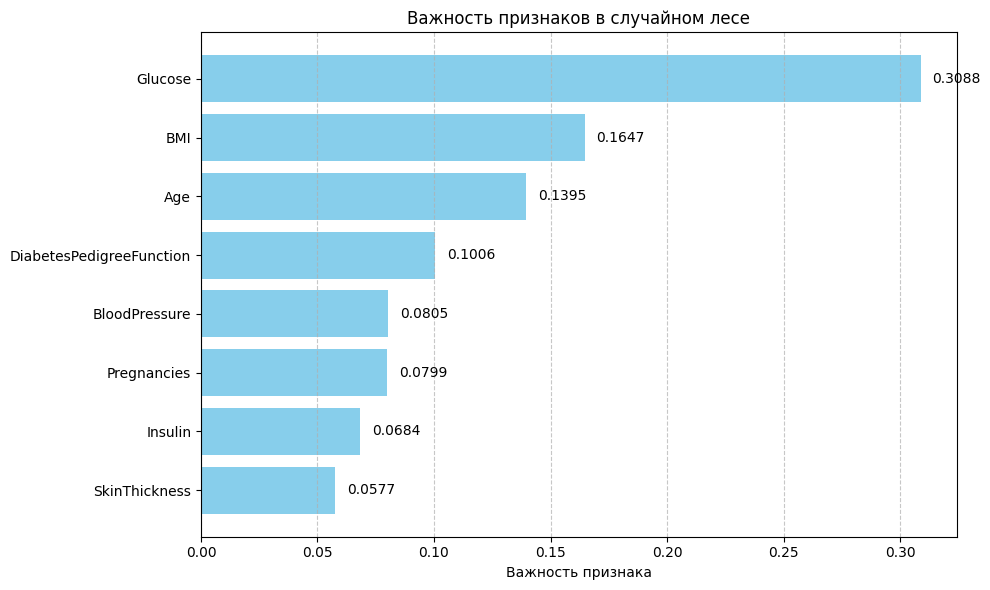

Самый важный признак: Glucose


In [22]:
importances = best_rf.feature_importances_
feature_names = X.columns

sorted_idx = importances.argsort()[::-1]
sorted_importances = importances[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Важность признака')
plt.title('Важность признаков в случайном лесе')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, v in enumerate(sorted_importances):
    plt.text(v + 0.005, i, f"{v:.4f}", va='center')

plt.tight_layout()
plt.show()

print("Самый важный признак:", sorted_feature_names[0])